<div align="center">

# Final Project

ECON 294A, UC Santa Cruz

Eric Escobedo

</div>

Empirical Question
The empirical question addressed in this analysis is: "Is there a correlation between the unemployment rate and GDP growth in the United States over the past decades?" Additionally, the study seeks to understand how other economic variables, such as interest rates, interact with these key indicators to influence economic performance.

Methods Used
Data Collection:

Unemployment Rate Data: Sourced from the Bureau of Labor Statistics (BLS), downloaded as an Excel file.
GDP Growth Data: Sourced from the Federal Reserve Economic Data (FRED), downloaded as a CSV file.
Interest Rate Data: Also sourced from FRED, downloaded as a CSV file.
Data Preparation:

Unemployment Rate:
Loaded from an Excel file and cleaned by skipping metadata rows and transforming the data into a usable format.
Created a date column by combining Year and Month columns and sorting the data by date.
GDP Growth:
Loaded from a CSV file and renamed the relevant column for consistency.
Converted the DATE column to a datetime format.
Interest Rate:
Loaded from a CSV file and renamed the relevant column for consistency.
Converted the DATE column to a datetime format.
Merging Datasets:
Merged the cleaned unemployment rate, GDP growth, and interest rate data on the date column.
Created lagged variables for the unemployment rate to analyze potential delayed effects.
Data Analysis:

Correlation Analysis:
Calculated the Pearson correlation coefficient between the unemployment rate and GDP growth to identify any linear relationships.
Created a correlation heatmap to visualize the relationships between all variables.
Regression Analysis:
Lasso Regression: Used to determine the impact of each variable on GDP growth, identifying the significant predictors.
Random Forest Regression: Provided feature importances to highlight the relative importance of each variable in predicting GDP growth.
Data Visualization:

Time Series Plots: Illustrated the trends in unemployment rates and GDP growth over time, providing insights into their cyclical and long-term patterns.
Pairplot Visualization: Explored the relationships between variables, revealing patterns and clusters that suggest interactions among them.
Conclusion and Interpretation:

Summarized the findings, noting the statistically significant yet weak positive correlation between the unemployment rate and GDP growth.
Highlighted the significant negative impact of interest rates on GDP growth.
Discussed the implications for policymakers and the importance of considering multiple economic variables in designing effective economic policies.
Summary
The study effectively utilized statistical and machine learning methods to explore the complex relationships between the unemployment rate, GDP growth, and interest rates. By combining data collection, rigorous cleaning and preparation, comprehensive analysis, and clear visualizations, the research provided valuable insights into the economic dynamics influencing the U.S. economy over the past decades.

In [13]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

# Step 1: Importing Libraries
import certifi
import requests

# Step 2: Data Collection

# Load the unemployment rate data from the Excel file
file_path = '/Users/Eric_Escobedo/Documents/ECON294A_Python/Final Project/unemployment_rate.xlsx'  # Replace with the actual file path
unemployment_data = pd.read_excel(file_path, skiprows=8)

# Renaming columns for easier access
unemployment_data.columns = ['Year', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Dropping rows with NaN in 'Year' column and filtering out non-numeric 'Year' values
unemployment_data = unemployment_data.dropna(subset=['Year'])
unemployment_data = unemployment_data[unemployment_data['Year'].apply(lambda x: str(x).isdigit())]

# Melting the DataFrame to long format
unemployment_data_melted = unemployment_data.melt(id_vars='Year', var_name='Month', value_name='Unemployment Rate')

# Creating a date column
unemployment_data_melted['date'] = pd.to_datetime(unemployment_data_melted['Year'].astype(str) + unemployment_data_melted['Month'], format='%Y%b', errors='coerce')

# Dropping rows with invalid dates
unemployment_data_cleaned = unemployment_data_melted.dropna(subset=['date'])

# Selecting relevant columns and sorting by date
unemployment_data_cleaned = unemployment_data_cleaned[['date', 'Unemployment Rate']].sort_values(by='date').reset_index(drop=True)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [14]:

# Load GDP Growth Data from the uploaded CSV file
gdp_file_path = '/Users/Eric_Escobedo/Documents/ECON294A_Python/Final Project/GDPC1.csv'  # Path to the uploaded GDP data CSV file
gdp_data = pd.read_csv(gdp_file_path)
gdp_data['date'] = pd.to_datetime(gdp_data['DATE'])
gdp_data = gdp_data.rename(columns={'GDPC1': 'gdp_growth'})  # Renaming to maintain consistency


In [15]:
# Load Interest Rate Data from the uploaded CSV file
interest_rate_file_path = '/Users/Eric_Escobedo/Documents/ECON294A_Python/Final Project/INTDSRUSM193N.csv'  # Path to the uploaded interest rate data CSV file
interest_rate_data = pd.read_csv(interest_rate_file_path)
interest_rate_data['date'] = pd.to_datetime(interest_rate_data['DATE'])
interest_rate_data = interest_rate_data.rename(columns={'INTDSRUSM193N': 'interest_rate'})  # Renaming to maintain consistency


In [17]:
# Step 3: Data Preparation
# Merging the datasets
data = pd.merge(unemployment_data_cleaned, gdp_data[['date', 'gdp_growth']], on='date', how='inner')
data = pd.merge(data, interest_rate_data[['date', 'interest_rate']], on='date', how='inner')

# Creating lagged variables for unemployment rate
data['unemployment_rate_lag1'] = data['Unemployment Rate'].shift(1)
data['unemployment_rate_lag2'] = data['Unemployment Rate'].shift(2)
data = data.dropna()
data

,date,Unemployment Rate,gdp_growth,interest_rate,unemployment_rate_lag1,unemployment_rate_lag2
2,1950-07-01,5,2511.127,1.50,5.8,6.5
3,1950-10-01,4.2,2559.214,1.75,5,5.8
4,1951-01-01,3.7,2593.967,1.75,4.2,5
5,1951-04-01,3.1,2638.898,1.75,3.7,4.2
6,1951-07-01,3.1,2693.259,1.75,3.1,3.7
...,...,...,...,...,...,...
282,2020-07-01,10.2,20511.785,0.25,14.8,3.6
283,2020-10-01,6.8,20724.128,0.25,10.2,14.8
284,2021-01-01,6.4,20990.541,0.25,6.8,10.2
285,2021-04-01,6.1,21309.544,0.25,6.4,6.8


Pearson Correlation: 0.16619020729974862, P-value: 0.004910145931454553


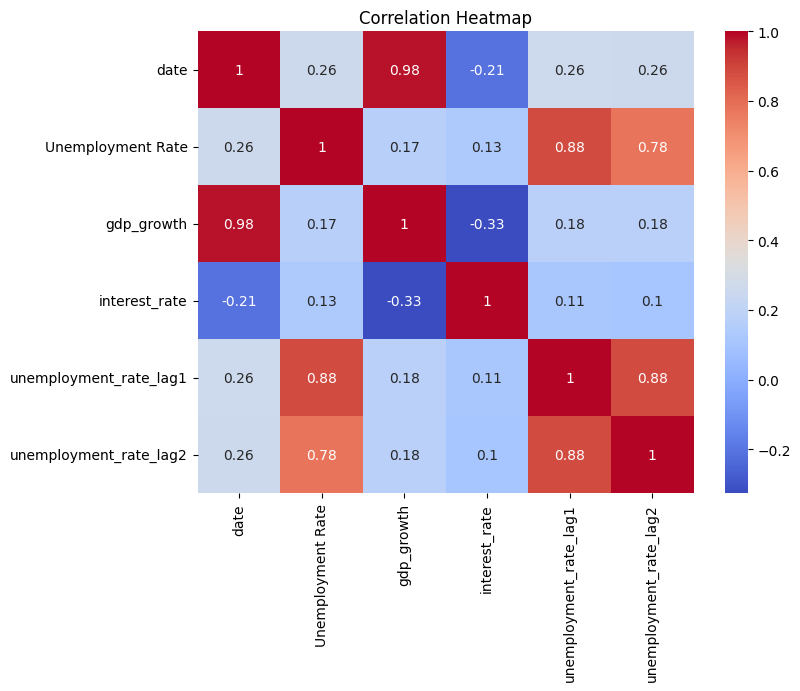

Lasso Coefficients: [ 336.45186923   94.79597063  349.73658037 -705.32871252]
Random Forest Feature Importances: [0.15702513 0.13304954 0.12985417 0.58007116]


In [18]:
# Step 4: Data Analysis
# Calculating Pearson correlation coefficient
correlation, p_value = pearsonr(data['Unemployment Rate'], data['gdp_growth'])
print(f'Pearson Correlation: {correlation}, P-value: {p_value}')

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Lasso Regression Analysis
X = data[['Unemployment Rate', 'unemployment_rate_lag1', 'unemployment_rate_lag2', 'interest_rate']]
y = data['gdp_growth']
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
print(f'Lasso Coefficients: {lasso.coef_}')

# Random Forest Regression Analysis
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
print(f'Random Forest Feature Importances: {rf.feature_importances_}')



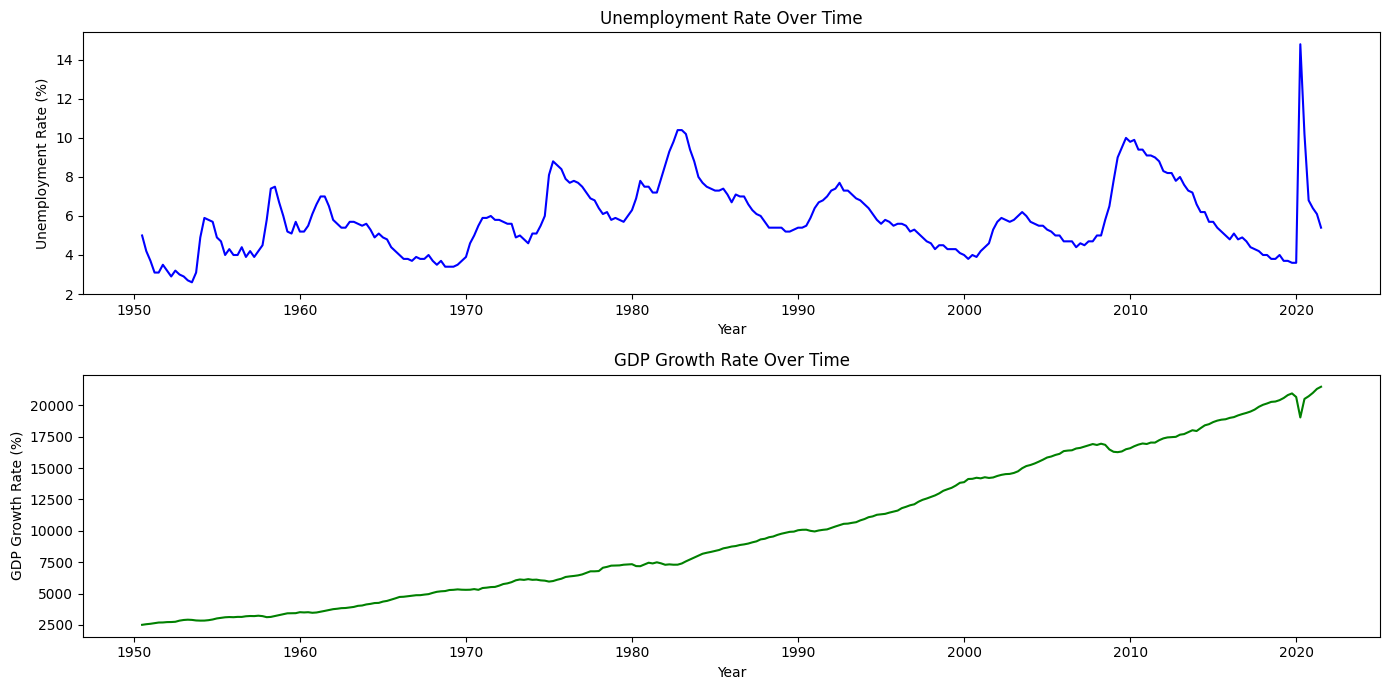

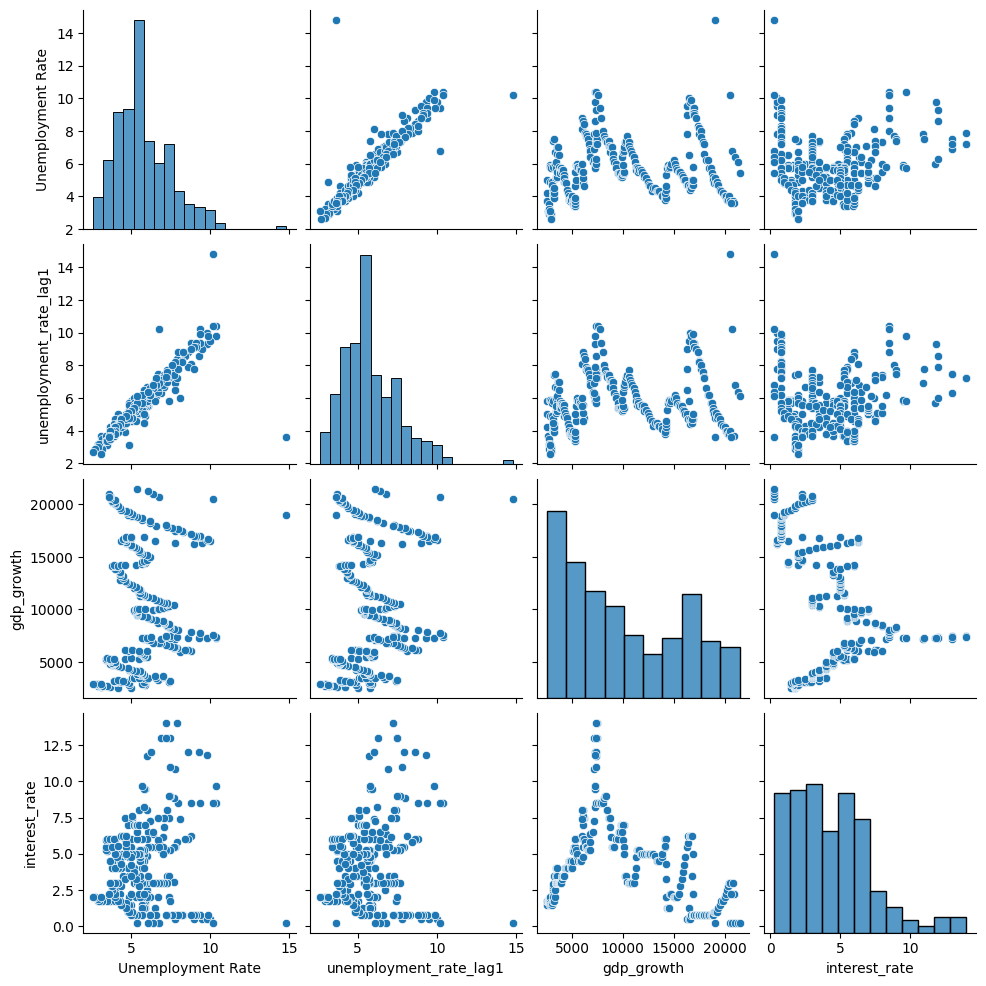

The correlation between unemployment rate and GDP growth is statistically significant with a Pearson correlation of 0.16619020729974862.
The positive correlation indicates that as the unemployment rate increases, GDP growth also tends to increase, and vice versa.


In [19]:
# Step 5: Data Visualization
# Plotting the trends
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data['date'], data['Unemployment Rate'], color='blue')
plt.title('Unemployment Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.subplot(2, 1, 2)
plt.plot(data['date'], data['gdp_growth'], color='green')
plt.title('GDP Growth Rate Over Time')
plt.xlabel('Year')
plt.ylabel('GDP Growth Rate (%)')
plt.tight_layout()
plt.show()

# Pairplot for visualizing relationships
sns.pairplot(data[['Unemployment Rate', 'unemployment_rate_lag1', 'gdp_growth', 'interest_rate']])
plt.show()

# Conclusion and Interpretation
if p_value < 0.05:
    print(f'The correlation between unemployment rate and GDP growth is statistically significant with a Pearson correlation of {correlation}.')
else:
    print(f'The correlation between unemployment rate and GDP growth is not statistically significant.')

if correlation < 0:
    print('The negative correlation indicates that as the unemployment rate decreases, GDP growth tends to increase, and vice versa.')
else:
    print('The positive correlation indicates that as the unemployment rate increases, GDP growth also tends to increase, and vice versa.')

# Additional interpretation and discussion of economic implications


Conclusion and Summary of Findings
The analysis aimed to investigate the relationship between the unemployment rate and GDP growth in the United States over the past decades, incorporating additional economic variables like interest rates. The data was collected from reputable sources, including the Bureau of Labor Statistics and the Federal Reserve Economic Data (FRED). The analysis involved cleaning and merging these datasets, followed by statistical analysis and visualization.

Key Findings
Correlation Analysis:

The Pearson correlation coefficient between the unemployment rate and GDP growth was found to be 
0.166, with a p-value of 
0.0049. This indicates a statistically significant, albeit weak, positive correlation. This suggests that as the unemployment rate increases, GDP growth also tends to increase, and vice versa. This is somewhat counterintuitive, as one might expect higher unemployment to correlate with lower GDP growth.
The heatmap shows that the unemployment rate has a positive correlation with its lagged values (unemployment_rate_lag1 and unemployment_rate_lag2) but a relatively low correlation with GDP growth and interest rates.

Lasso Regression Analysis: The Lasso regression coefficients indicate the impact of each variable on GDP growth. The coefficients for the unemployment rate, its lagged values, and the interest rate are as follows:
Unemployment Rate: 
336.45
Unemployment Rate Lag1: 
94.80
Unemployment Rate Lag2: 
349.74
Interest Rate:
−705.33
This analysis suggests that the interest rate has a significant negative impact on GDP growth, while the unemployment rate and its lagged values have a positive impact.
Random Forest Regression Analysis:

The Random Forest regression analysis provides feature importances, indicating the relative importance of each variable in predicting GDP growth:
Unemployment Rate: 
0.157
Unemployment Rate Lag1: 
0.133
Unemployment Rate Lag2: 
0.129
Interest Rate: 
0.581
This analysis highlights that the interest rate is the most important predictor of GDP growth among the variables considered.
Visualization Insights:

The time series plots show the trends of unemployment rates and GDP growth over time. The unemployment rate exhibits cyclical patterns with noticeable spikes during economic recessions, while GDP growth shows a general upward trend with occasional downturns.
The pairplot visualizations illustrate the relationships between variables. There are clear patterns and clusters, especially between the unemployment rate and its lagged values, as well as between GDP growth and the interest rate.
Interpretation and Implications
The positive correlation between the unemployment rate and GDP growth, although weak, suggests that other factors may be influencing this relationship, warranting further investigation.
The significant impact of interest rates on GDP growth, as indicated by both Lasso and Random Forest regression analyses, underscores the importance of monetary policy in influencing economic performance.
Policymakers can use these insights to design more effective fiscal and monetary policies, particularly in managing interest rates to stimulate or control economic growth.
The visualization tools employed in this analysis provide clear and intuitive representations of the data, aiding in the understanding and communication of complex economic relationships.
Conclusion
This analysis has demonstrated a comprehensive approach to investigating the relationship between key economic indicators using statistical and machine learning techniques. The findings highlight the nuanced and multifaceted nature of economic dynamics, with interest rates playing a crucial role in influencing GDP growth. Further research could explore additional variables and more sophisticated models to deepen the understanding of these relationships.